# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.


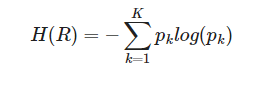

In [92]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
import math
p1=8/10 #Нашли вероятности
p2=2/10
H=round(-(p1*math.log(p1)+p2*math.log(p2)),2) #Используем формулу с семинара (фото прикрепила выше) + функцию round для округления
print('Энтропия распределения классов равна:',H)
#Попробуем решить с помощью нампая, без модуля math
k1=np.array([p1]) #Вероятности
k2=np.array([p2])
H2=round(-(float(k1*np.log(k1))+float(k2*np.log(k2))),2) #np.log для логарифма, остальное то  же самое
print('Энтропия распределения классов равна:',H2)

Энтропия распределения классов равна: 0.5
Энтропия распределения классов равна: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [93]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
Rm=10 #Исходное множество содержит 10 объектов
Rl=8 #В левое дерево попадут все k1 -те 8 штук
Rr=2 #В правое все k2 - 2 штуки
p1=Rl/Rm #Вероятность k1 в множестве Rm + соотношение объектов в множестве Rl
p2=Rr/Rm #Вероятность k2 в множестве Rm + соотношение объектов в множестве Rr
HRm=p1*(1-p1)+p2*(1-p2) #Считаем H(Rm) по индексу Джини
Hrl=1*(1-1) #Считаем H в множествах Rl и Rm, здесь энтропия будет равна 0, так как у нас нет хаотичности в множестве (в множестве все объекты одного класса)
Hrr=1*(1-1)
Q=round(HRm-p1*Hrl-p2*Hrr,2) #Считаем критерий информативности и округляем 
print('Критерий информативности равен:', Q)

Критерий информативности равен: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [94]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
Objects=np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]) 
Predict=np.mean(Objects) #Тк у нас задача регрессии и все объеты попали в одну листовую вершину, то предсказание для них одинаковое - это их среднее значение
print('Предсказания модели для объектов равны:',Predict)

Предсказания модели для объектов равны: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [95]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

1 Вариант - функция с циклом для перебора порогов (далее сделаю функцию 
`find_best_split2()` без цикла):

In [96]:
#Вариант 1 - с использованием цикла
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    #Для начала определим, как будем считать меру хаотичности в зависимости от задачи + зададим функции для этих мер
    def disp(x):
        return np.var(x) #Ищем дисперсию
    def gini(x):
      m,counts=np.unique(x, return_counts=True) #Считаем уникальные элементы
      pr=counts/len(x)#Ищем их вероятности делением на общую размерность множества
      return 1-np.sum(pr**2) #Если раскорем скобки из прошлго задания, то получим сумму веротяностей - сумму каждой из веротяностей в квадрате, сумма всех вероятностей - это 1
      #поэтому можем записать результат как 1 - сумма квадратов вероятностей 
      
    if task=='regression':
      criterii=disp
    else:
      criterii=gini
    # Теперь найдем вектор порогов в зависимости от задачи
    if feature_type=="real": 
        help_vec=np.sort(feature_vector) #Отсортируем значения признака
        thresholds=np.unique(help_vec[:-1]+help_vec[1:])/2 #Берем среднее двух соседних, берем уникальные значения, тк если пороги будут повторяться, то и разбиения будет одинаковым
        #чтобы разбиения не повторялись, возьмем только уникальные значения
    elif feature_type=="categorical":
        thresholds=np.sort(np.unique(feature_vector))#Берем уникальные значения и сортируем их

    if len(thresholds)==1:#Если у нас всегда одно значение признака, то есть он константный, то просто поделим выборку на 2 (тк поведение функции может быть любым)
      if len(target_vector)%2==0:
        ind_stop=int(len(target_vector)/2) #находим индекс, который делит выборку на 2
        left_Rl=target_vector[:ind_stop] #левая ветка дерева
        right_Rr=target_vector[ind_stop:] #правая
      else:
        ind_stop=int(len(target_vector)/2) #Если выборка нечетная - "округляем вниз" с помощью int
        left_Rl=target_vector[:ind_stop]
        right_Rr=target_vector[ind_stop:]
      Q=criterii(target_vector)-(len(left_Rl)/len(target_vector))*criterii(left_Rl)-criterii(right_Rr)*(len(right_Rr)/len(target_vector))#Считаем критерий
      threshold_best=thresholds[0] #Тк у нас всего 1 порог, то он и будет лучшим
      return thresholds[0], Q, threshold_best, Q #У нас 1 критерий и один порог, то есть мы можем возвращать не массив, а просто одно значение

    #Сначала разберемся с вещественным признаком:
    if feature_type=="real":
      ginis=np.array([]) #Сюда будем записывать критерии информативности
      for threshold in thresholds:
        left_index=feature_vector <= threshold #Сделаем маску для объектов "меньше порога"
        right_index=feature_vector > threshold #Сделаем маску для объектов "больше порога"
        left_Rl=target_vector[left_index] #Нашли элементы, которые попадут в левую вершину
        right_Rr=target_vector[right_index] #Нашли элементы, которые попадут в правую вершину
        Q=criterii(target_vector)-(len(left_Rl)/len(target_vector))*criterii(left_Rl)-criterii(right_Rr)*(len(right_Rr)/len(target_vector))#Считаем критерий
        ginis=np.append(ginis, Q)#Добавляем его в итоговый вектор критериев
      gini_best=max(ginis)# Лучший критерий - максимальный, тк у нас энтропия 1 + энтропия 2 стремится к минимуму, мы вычитаем эту сумму из начальной энтропии =>устремляем
      #значение критерия к максимуму
      ind_best=np.where(ginis==gini_best)[0][0] #находим индекс лучшего критерия (если одинаковые - берем минимальный по условию)
      threshold_best=thresholds[ind_best]#Находим лучший порог по индексу
      return thresholds, ginis, threshold_best, gini_best

     #Теперь разберемся с категориальным признаком:  
    if feature_type=="categorical":
      ginis=np.array([])#Сюда будем записывать критерии информативности
      for threshold in thresholds:
        left_index=feature_vector == threshold #Сделаем маску "равенство" признаку
        right_index=feature_vector != threshold #Сделаем маску "неравенство" признаку
        left_Rl=target_vector[left_index] #Нашли элементы, которые попадут в левую вершину
        right_Rr=target_vector[right_index] #Нашли элементы, которые попадут в правую вершину
        Q=criterii(target_vector)-(len(left_Rl)/len(target_vector))*criterii(left_Rl)-criterii(right_Rr)*(len(right_Rr)/len(target_vector))#Считаем критерий
        ginis=np.append(ginis, Q)#Добавляем его в итоговый вектор критериев
      gini_best=max(ginis)# Лучший критерий - максимальный, тк у нас энтропия 1 + энтропия 2 стремится к минимуму, мы вычитаем эту сумму из начальной энтропии =>утремляем
      #значение критерия к максимуму
      ind_best=np.where(ginis==gini_best)[0][0] #находим индекс лучшего критерия (если одинаковые - берем минимальный по условию)
      threshold_best=thresholds[ind_best]#Находим лучший порог по индексу
      return thresholds, ginis, threshold_best, gini_best

    pass

Вариант 2 - реализация без цикла

In [97]:
#Вариант 2 - без цикла
def find_best_split2(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    #Для начала определим, как будем считать меру хаотичности в зависимости от задачи + зададим функции для этих мер
    def disp(x):
        return np.var(x) #Ищем дисперсию
    def gini(x):
      m,counts=np.unique(x, return_counts=True) #Считаем уникальные элементы
      pr=counts/len(x)#Ищем их вероятности делением на общую размерность множества
      return 1-np.sum(pr**2) #Если раскорем скобки из прошлго задания, то получим сумму веротяностей - сумму каждой из веротяностей в квадрате, сумма всех вероятностей - это 1
      #поэтому можем записать результат как 1 - сумма квадратов вероятностей 
      
    if task=='regression':
      criterii=disp
    else:
      criterii=gini
    # Теперь найдем вектор порогов в зависимости от задачи
    if feature_type=="real": 
        help_vec=np.sort(feature_vector) #Отсортируем значения признака
        thresholds=np.unique(help_vec[:-1]+help_vec[1:])/2 #Берем среднее двух соседних
    elif feature_type=="categorical":
        thresholds=np.sort(np.unique(feature_vector))#Берем уникальные значения и сортируем их 

    if len(thresholds)==1:#Если у нас всегда одно значение признака, то есть он константный, то просто поделим выборку на 2 (тк поведение функции может быть любым)
      if len(target_vector)%2==0:
        ind_stop=int(len(target_vector)/2) #находим индекс, который делит выборку на 2
        left_Rl=target_vector[:ind_stop] #левая ветка дерева
        right_Rr=target_vector[ind_stop:] #правая
      else:
        ind_stop=int(len(target_vector)/2) #Если выборка нечетная - "округляем вниз" с помощью int
        left_Rl=target_vector[:ind_stop]
        right_Rr=target_vector[ind_stop:]
      Q=criterii(target_vector)-(len(left_Rl)/len(target_vector))*criterii(left_Rl)-criterii(right_Rr)*(len(right_Rr)/len(target_vector))#Считаем критерий
      threshold_best=thresholds[0] #Тк у нас всего 1 порог, то он и будет лучшим
      return thresholds[0], Q, threshold_best, Q #У нас 1 критерий и один порог, то есть мы можем возвращать не массив, а просто одно значение


    #Сначала разберемся с вещественным признаком
    if feature_type=="real":
      def criter_func(threshold): #Сюда будут подаваться значения из массива порогов
        left_index=feature_vector <= threshold #Маска для объектов, которые "меньше порога"
        right_index=feature_vector > threshold #Маска для объектов, которые "больше порога"
        left_Rl=target_vector[left_index] #Нашли элементы, которые попадут в левую вершину
        right_Rr=target_vector[right_index] #Нашли элементы, которые попадут в правую вершину
        Q=criterii(target_vector)-(len(left_Rl)/len(target_vector))*criterii(left_Rl)-criterii(right_Rr)*(len(right_Rr)/len(target_vector))#Считаем критерий
        return Q #Возвращаем критерий
    #Теперь разберемся с категориальным признаком
    elif feature_type=="categorical":
      def criter_func(threshold):
        left_index=feature_vector == threshold #Маска для элементов, которые "меньше порога"
        right_index=feature_vector != threshold #Маска для элементов, которые "больше порога"
        left_Rl=target_vector[left_index] #Нашли элементы, которые попадут в левую вершину
        right_Rr=target_vector[right_index] #Нашли элементы, которые попадут в правую вершину
        Q=criterii(target_vector)-(len(left_Rl)/len(target_vector))*criterii(left_Rl)-criterii(right_Rr)*(len(right_Rr)/len(target_vector))#Считаем критерий
        return Q
    vfunc=np.vectorize(criter_func) #Векторизация для написанной выше функции
    ginis=vfunc(thresholds) #Создаем массив критериев информативности Джини с помощью векторизатора
    gini_best=max(ginis)# Лучший критерий - максимальный, тк у нас энтропия 1 + энтропия 2 стремится к минимуму, мы вычитаем эту сумму из начальной энтропии =>утремляем
    #значение критерия к максимуму
    ind_best=np.where(ginis==gini_best)[0][0] #находим индекс лучшего критерия (если одинаковые - берем минимальный по условию)
    threshold_best=thresholds[ind_best]#Находим лучший порог по индексу
    return thresholds, ginis, threshold_best, gini_best
    pass

Эту функцию можно протестировать на датасете `California`.

In [98]:
from sklearn.datasets import fetch_california_housing

In [99]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [100]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


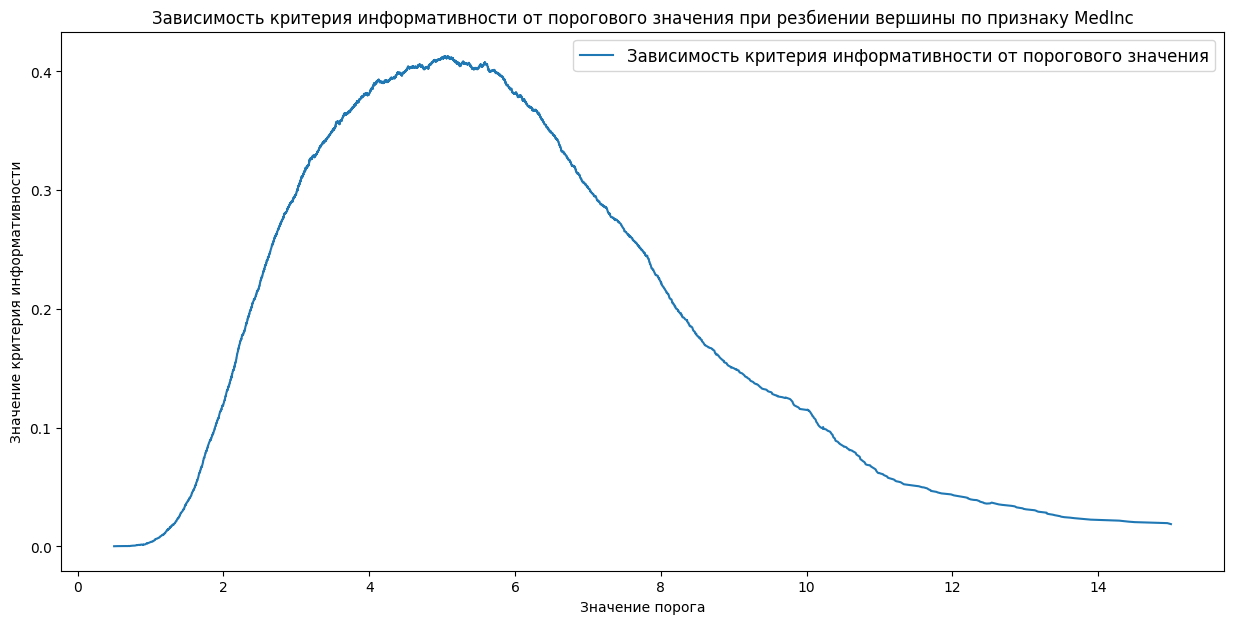

In [101]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
#Проверим сначала первую функцию с циклом, потом сделаем то же самое для второй (без цикла) - если они совпадут, то должно быть все ок
Info=find_best_split(X.MedInc,y,task='regression') #Применим функцию, она даст нам 2 массива и 2 значения
porogi=Info[0] #Первый массив - это пороги
Ginis=Info[1] #Второй -значения критерия информативности
plt.figure(figsize=(15, 7))
plt.plot(porogi,Ginis,label=r'Зависимость критерия информативности от порогового значения') #Строим график
plt.title(r'Зависимость критерия информативности от порогового значения при резбиении вершины по признаку MedInc')
plt.xlabel(r'Значение порога', fontsize=10)
plt.ylabel(r'Значение критерия информативности', fontsize=10)
plt.legend(loc='best', fontsize=12)
plt.show() 

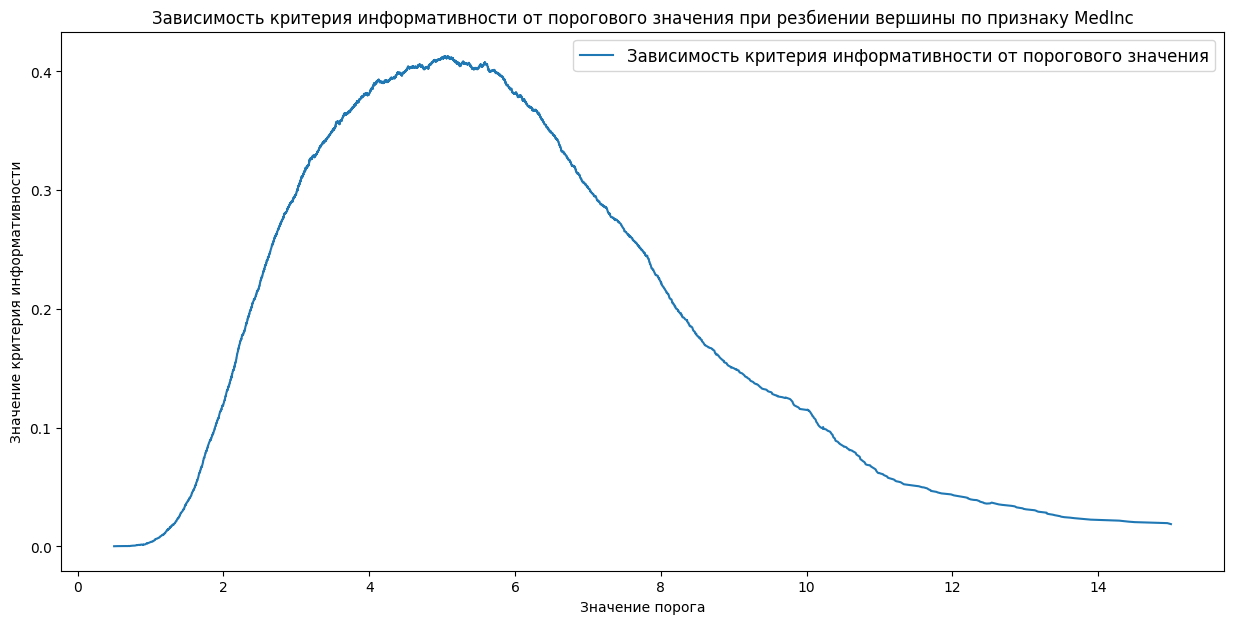

In [102]:
#Проверим вторую функцию
Info2=find_best_split2(X.MedInc,y,task='regression')
porogi2=Info2[0]
Ginis2=Info2[1]
plt.figure(figsize=(15, 7))
plt.plot(porogi2,Ginis2,label=r'Зависимость критерия информативности от порогового значения')
plt.title(r'Зависимость критерия информативности от порогового значения при резбиении вершины по признаку MedInc')
plt.xlabel(r'Значение порога', fontsize=10)
plt.ylabel(r'Значение критерия информативности', fontsize=10)
plt.legend(loc='best', fontsize=12)
plt.show() #Вроде все хорошо, графики совпадают

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [103]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
#Лучший предикат в нашей функции воводился 3 значением (threshold_best), достанем его из значений Info выше
print('Лучший предикат согласно функции find_best_split:',Info[2])
print('Лучший предикат согласно функции find_best_split2:',Info2[2]) #Ура они совпали!

Лучший предикат согласно функции find_best_split: 5.03515
Лучший предикат согласно функции find_best_split2: 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [104]:
# Я попыталась сделать бонусные задания, их реализация внутри класса 
# способ обработки пропусков у меня идет после for feature in range
# метод оценки важности признака почти там же, после if gini_best is None or gini > gini_best
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {} #будем записывать сюда значения (после того, как найдем feature_best ниже, реализация в цикле for feature in range...)
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
            ###Реализуем способ обработки пропусков в данных
                feature_vector = sub_X[:, feature]
                feature_vector2=pd.DataFrame(feature_vector)#Сделаем вспомогательный ДФ, это мне надо для нахождения среднего с помощью метода в пандас
                nan_inf=feature_vector2.mean() #Заменим все пропуски на среднее значение, тк признак у нас вещественный
                feature_vector=np.nan_to_num(feature_vector, nan=nan_inf)#Заменяем изначальный массив
            ###
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]
                feature_vector2=pd.DataFrame(feature_vector)#Сделаем вспомогательный ДФ, это мне надо для нахождения моды с помощью метода в пандас
                nan_inf=feature_vector2.mode()[0] #Заменим все пропуски на самое популярное значение - моду (для категориального признака), если их
                #будет несколько, то просто возьмем первое (для этого индекс [0])
                feature_vector=np.nan_to_num(feature_vector, nan=nan_inf)
                 
                #feature_vector[feature].fillna(feature_vector[feature].mode()[0], inplace=True)
                #feature_vector=np.array(feature_vector)[:,0]#Преобразуем обратно в вектор

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                ### Здесь оцениваем важность признака
                #Логика такая: мы ищем feature_best, то есть лучший признак для разбиения, который по функции, реализованной выше, находит gini_best, то есть
                #такое значение, которое сильнее всего уменьшает хаотичность (максимизирует критерий информативности), то есть это и есть наш "лучший\важный" признак
                #Тогда можно просто записывать в словарь количество раз, которое вы выбирали конктерный признак "лучшим". Тот признак, у которого значение 
                # в итоговом словаре будет наибольшим - является самым важным, тк именно по нему мы больше всего разбивали вершины 
                if feature_best in self._feature_importances: #Если признак уже есть в словаре, то просто добавим к нему +1
                  self._feature_importances[feature_best]+=1
                else: #Если его нет в словаре, то присвоим ему значение 1 (тк он встречается первый раз)
                  self._feature_importances[feature_best]=1 #В самом конце класса еще определим функцию feature_imp, которая нам будет возвращать словарь с "рейтингом" признаков
                ###
                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector<=threshold_best# в левое поддерево берем объекты, которые меньше\равны порогу
                    
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector==threshold_best# здесь берем объекты, которые равны порогу 
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node["type"]=="terminal": #Если попадаем в листовую вершину
            return node["class"]#то просто выводим класс, который в ней написан
        else:
            feature_split=node['feature_split'] #берем признак (лучший признак - feature_best который мы нашли выше)
            if self._feature_types[feature_split]=="real": #проверяем, является ли он вещественным
                threshold=node['threshold'] #Если да, то мы ищем лучший предикат (threshold_best найден уже в функции выше и записан)
                if x[feature_split]<=threshold: #Если у нового объекта признак меньше порога, то отправлем его в левую ветку, а если больше - то в правую (рекурсивно)
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            elif self._feature_types[feature_split]=="categorical": #То же самое для категориального признака, но тут мы просто сравниваем (равен наш признак порогу или нет)
                category_split=node['category_split']
                if x[feature_split]==category_split:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            else:
                raise ValueError #Если ничего не получилось (признак не вещественный и не категориальный), то напишем, что произошла ошибка
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)
    def feature_imp(self) -> dict: #Это функция для вывода словаря, который оценивает важность призаков. Чем больше значение у признака, тем он важнее
        return self._feature_importances

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

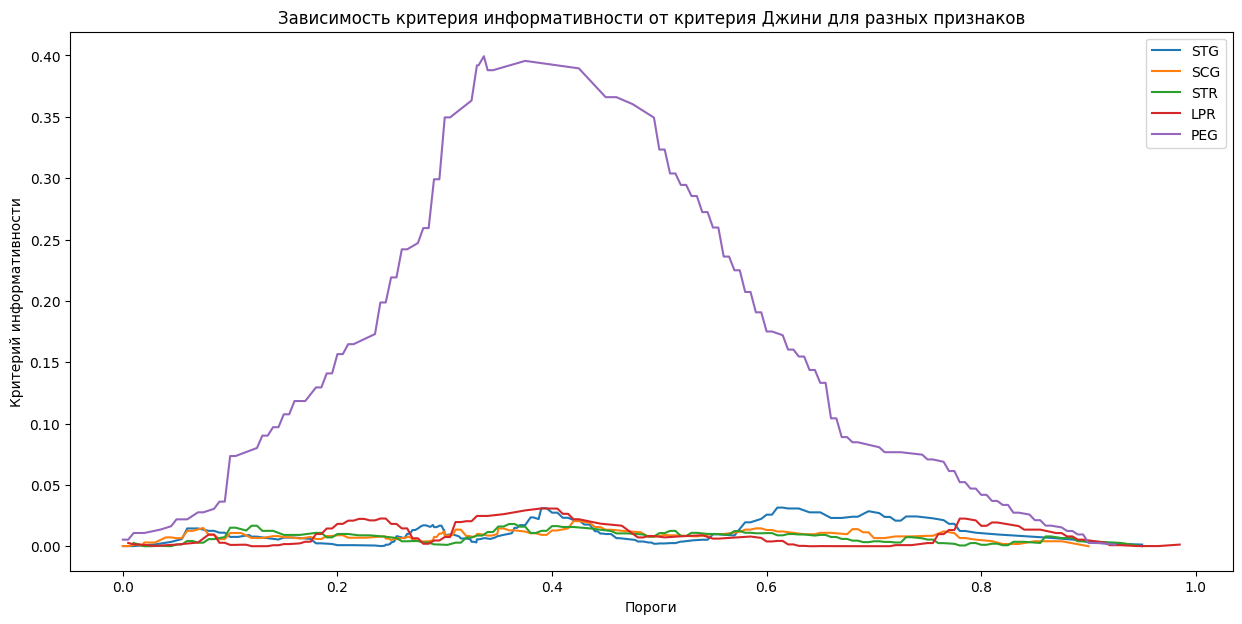

In [105]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
df = pd.read_csv(
    "https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/students.csv",
    sep=",",)
df=df.iloc[:,1:] #Убрали первый столбец, там были индексы
features=['STG', 'SCG', 'STR', 'LPR', 'PEG'] #Сюда запишем названия призаков
X=df.iloc[:, :5] #Вся таблица признаков
y=df.iloc[:, -1] #Таблица целевой переменной
plt.figure(figsize=(15, 7))
for feature in features: #проходимся по каждому признаку
  result=find_best_split(X[feature],y,task='classification',feature_type="real") #Применяем нашу функцию из первого задания, записываем все в переменную result
  porogi=result[0]#Пороги у нас возвращаюся первым массивом, а критерий информативности - вторым
  ginis=result[1]
  plt.plot(porogi, ginis, label=feature)#строим
plt.legend()
plt.xlabel('Пороги')
plt.ylabel('Критерий информативности')
plt.title('Зависимость критерия информативности от критерия Джини для разных признаков')
plt.show()

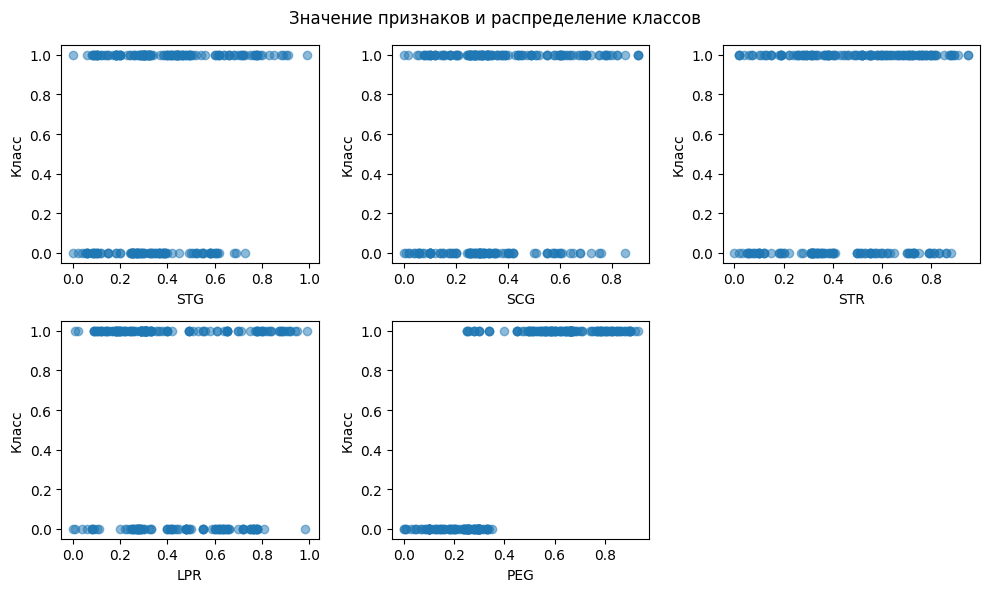

In [106]:
# Здесь сделаем диаграммы рассеяния для каждого признака
fig=plt.figure(figsize=(10, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1) #будем добавлять доп диаграмму с каждым новым призаком
    plt.scatter(X[feature], y, alpha=0.5) #Делаем диаграмму рассеяния по значению призака (выше мы их записали в список)
    plt.xlabel(feature)
    plt.ylabel('Класс')
fig.suptitle('Значение признаков и распределение классов')
fig.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [107]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
#Я так понимаю, мы здесь пишем только выводы, но вы просили писать их в текстовых ячейках, поэтому напишу ниже текстом

Выводы:
1.   Исходя из кривых значений критерия информативности, производить деление выборки на 2 поддерева нужно по признаку 'PEG', так как именно у этого признака наибольший критерий информативности при определенных значениях порога (он увеличивается, а мы как раз и устремляем его к максимуму, чтобы уменьшить хаотичность в выборке). У всех остальных признаков критерий информативности почти не меняется при изменении порогов
2.   Да, этот результат согласуется с визуальной оценкой диаграмм рассеяния.Мы видим, что значение порога чуть меньшее 0,4 полностью отделяет 0 класс от 1 (то есть все, что выше 0.4 - это уже 100% класс 1, и если мы будем так разбивать нашу выборку, то в одну из вершин попадут значения только класса 1 => хаотичность в этой вершине будет вообще нулевая => это устремит значение критерия информативности к максимуму). В других классах наоборот, нет такого четкого порога, который бы отделял один класс от другого
3. Кривая для "хороших" призаков - это такая кривая, которая имеет вид "нормального распределения". То есть у нее есть значительный подъем по оси Оу (критерию информативности), а потом спад
4. Кривые для признаков, по которым деление практически невозможно отличаются тем, что они почти всегда имеют константное значение для критерия информативности, они просто напоминают горизонтальную прямую. То есть как бы мы не разбивали выборку по порогу, критерий информативности (ось Оу) почти никак не меняется



**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [108]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#df=pd.read_csv(
    #"https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header=None) - почему-то у меня перестала работать ссылка из задания, я нашла 
    # эту таблицу на гитхабе и скачала оттуда, но на всякий случай ссылку из задания тоже оставлю
df=pd.read_csv('https://raw.githubusercontent.com/KatherineEvers/Mushroom-Data/master/agaricus-lepiota.data', header=None)
le=LabelEncoder()
for col in df.columns:
    df[col]=le.fit_transform(df[col]) #применили LabelEncoder для каждого столбца
X=df.iloc[:, 1:] #Берем все признаки
y=df.iloc[:, 0] #Берем первый столбец как целевую переменную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) #Делим выборку на половину (тк обучаем на половине)
params=pd.DataFrame(df.dtypes) #Делаем дф из значений признаков, они у нас все по условию категориальные
params=params.replace(['int64','int32'], 'categorical') #Передаем значение "категориальные" вместо int64, это нам нужно, чтобы наше дерево работало (ему нужны типы значений каждого из признаков)
dt=DecisionTree(np.array(params)) #Решающее дерево, передаем ему массив из типов значений признаков
dt.fit(np.array(X_train), np.array(y_train)) #Обучаем
y_pred=dt.predict(np.array(X_test)) #Предсказываем
accuracy=accuracy_score(y_pred,y_test) #Вычисляем долю верных ответов
print('Accuracy:', accuracy)

Accuracy: 1.0


In [109]:
#Я еще делала словарь с важностью признаков, можно посмотреть, получилось ли что-то
ft=dt.feature_imp()
ft#Вроде получилось, самый 1 признак оказался самым важным, тк мы разбивали по нему 15 раз

{0: 15, 1: 5, 3: 7, 4: 4, 2: 7, 8: 1, 19: 1, 12: 2, 14: 1, 7: 3, 10: 2}

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [110]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [111]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/diabetes.csv',
    sep=",",)
#data = pd.read_csv('diabetes.csv') - я скачала из домашки ссылкой сразу
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

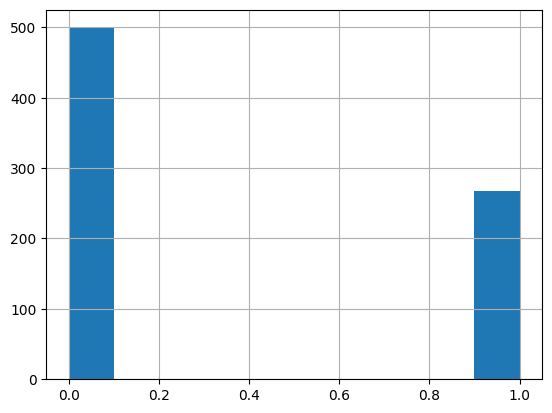

In [112]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [113]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
X=pd.DataFrame(data=data.iloc[:,:-1]) #Взяли признаки
y=pd.DataFrame(data=data["Outcome"]) #Взяли целевую переменную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)#Разбили на обучающую и тестовую части
X_train_train, X_train_val, y_train_train, y_train_val=train_test_split(X_train, y_train, test_size=0.3, random_state=42)#Разбили на обучающую и валидационную

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [114]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
#1
max_depth_list=[3, 5, 7, 9, 11, 13] #Возьмем несколько значений для перебора
min_samples_leaf_list=[1, 3, 5, 7, 9, 11] #Тоже возьмем какие-то значения
best_accuracy=[0,0,0]#Сюда будем записывать 1 - лучшую глубину, 2-лучшее значение min_samples_leaf, 3-значение f1-меры
for depth in max_depth_list:
  for leaf in min_samples_leaf_list: #Пробегаемся по листам и глубине
    dt=DecisionTreeClassifier(random_state=13,max_depth=depth, min_samples_leaf=leaf )#пишем их в виде параметров для дерева
    dt.fit(X_train_train, y_train_train)#обучаем
    y_pred_dt=dt.predict(X_train_val)#Ищем предсказание на валидационной выборке
    score=f1_score(y_pred_dt, y_train_val)#Ищем f1-меру
    if best_accuracy[2]<score:#Если у нас при данной паре f1-мера стала больше, то мы в наш список записываем новые значения гиперпараметров, иначе - просто оставляем прежние
      best_accuracy[0]=depth
      best_accuracy[1]=leaf
      best_accuracy[2]=score
dt=DecisionTreeClassifier(random_state=13,max_depth=best_accuracy[0], min_samples_leaf=best_accuracy[1] )#Обучаем с подобранными гиперпараметрами на всей обучающей выборке
dt.fit(X_train, y_train)
y_pred_dt=dt.predict(X_test)#Ищем предсказание
print('Accuracy:', accuracy_score(y_pred_dt, y_test)) #Считаем метрики
print('Precision:', precision_score(y_pred_dt, y_test))
print('Recall:', recall_score(y_pred_dt, y_test))
print('AUC-ROC:', roc_auc_score(y_pred_dt, y_test))

Accuracy: 0.696969696969697
Precision: 0.625
Recall: 0.5555555555555556
AUC-ROC: 0.6713947990543735


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [115]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
dt=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=13, max_depth=best_accuracy[0], min_samples_leaf=best_accuracy[1]), n_estimators=50, random_state=42)
#Делаем бэггинг, гиперпараметры оставим из предыдущего задания
dt.fit(X_train, y_train)#Обучаем
y_pred_dt=dt.predict(X_test)#Предсказание
print('Accuracy:', accuracy_score(y_pred_dt, y_test))#Считаем качество по метрикам
print('Precision:', precision_score(y_pred_dt, y_test))
print('Recall:', recall_score(y_pred_dt, y_test))
print('AUC-ROC:', roc_auc_score(y_pred_dt, y_test))

Accuracy: 0.7575757575757576
Precision: 0.6625
Recall: 0.6463414634146342
AUC-ROC: 0.7325667048616795


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [116]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import cross_val_score
max_depth_list=[5, 11, 13, 17, 23]#То же самое, рандомные числа для глубины
min_samples_leaf_list=[2,  5,  10, 19]#Аналогично
best_accuracy=[0,0,0]#Сюда опять будем записывать лучшие гиперпараметры и f1-меру при них
for depth in max_depth_list:
  for samp in min_samples_leaf_list:#Циклом создаем пары гиперпараметров
        dt=RandomForestClassifier(n_estimators=50, random_state=42, max_depth=depth, min_samples_split=samp) 
        f1_scores=cross_val_score(dt, X_train, y_train, cv=5, scoring='f1')#Выполняем кросс-валидацию на полной обучающей выборке, меры записываем в переменную f1_scores, сv взяла равным 5
        score=f1_scores.mean()#Ищем среднее, тк мы делали кросс-валидацию
        if best_accuracy[2]<score:#Если находим f1-меру лучше, чем она была - меняем гиперпараметры в списке
          best_accuracy[0]=depth
          best_accuracy[1]=samp
          best_accuracy[2]=score
dt=RandomForestClassifier(n_estimators=50, random_state=42, max_depth=best_accuracy[0], min_samples_split=best_accuracy[1])#Обучаем с подобранными гиперпараметрами
dt.fit(X_train, y_train)
y_pred_dt=dt.predict(X_test)#Предсказание
print('Accuracy:', accuracy_score(y_pred_dt, y_test))#Считаем метрики
print('Precision:', precision_score(y_pred_dt, y_test))
print('Recall:', recall_score(y_pred_dt, y_test))
print('AUC-ROC:', roc_auc_score(y_pred_dt, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Accuracy: 0.7575757575757576
Precision: 0.675
Recall: 0.6428571428571429
AUC-ROC: 0.7329931972789115


<ipython-input-116-650a1d58ef62>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  dt.fit(X_train, y_train)


Выводы:
1. По метрике Accuracy лучше всего были модели, обученные по RandomForestClassifier и BaggingClassifier
2. По метрике Precision лучше всего была модель, обученная по RandomForestClassifier
3. По метрике Recall лучше всего была модель, обученная по BaggingClassifier
4. По метрике AUC-ROC лучше всего была модель, обученная по RandomForestClassifier

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

<ipython-input-117-b653b5fd96fe>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  dt.fit(X_train, y_train)#Обучаем на полной обучающей выборке
<ipython-input-117-b653b5fd96fe>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  dt.fit(X_train, y_train)#Обучаем на полной обучающей выборке
<ipython-input-117-b653b5fd96fe>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  dt.fit(X_train, y_train)#Обучаем на полной обучающей выборке
<ipython-input-117-b653b5fd96fe>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  dt.fit(X_train, y_train)#Обучаем на полной об

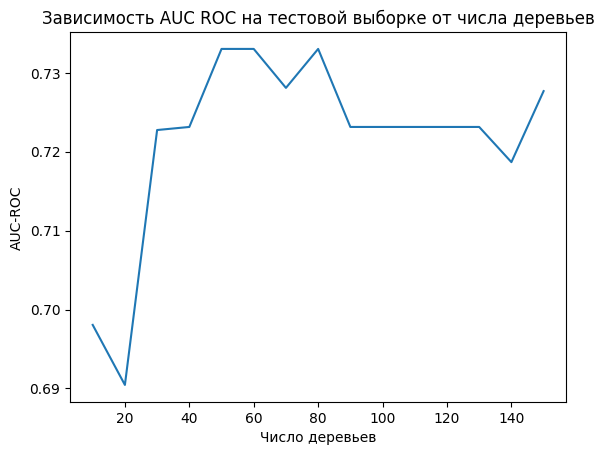

In [117]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
n_estimators_values=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120,130,140,150] #Запишем возможное количество деревьев
auc_roc_scores = []#Сюда будем добавлять значения AUC ROC 
for n_estimators in n_estimators_values:
    dt=RandomForestClassifier(n_estimators=n_estimators, random_state=42, max_depth=best_accuracy[0], min_samples_split=best_accuracy[1])#Берем гиперпараметры из прошлого задания
    dt.fit(X_train, y_train)#Обучаем на полной обучающей выборке
    y_pred_dt=dt.predict(X_test)#Делаем предсказание
    auc_roc_score=roc_auc_score(y_pred_dt, y_test)#Считаем AUC ROC для тестовой выборки
    auc_roc_scores+=[auc_roc_score]#Добавляем значение в список

plt.plot(n_estimators_values, auc_roc_scores)
plt.xlabel('Число деревьев')
plt.ylabel('AUC-ROC')
plt.title('Зависимость AUC ROC на тестовой выборке от числа деревьев')
plt.show()

Выводы: при небольшом числе деревьев (10-20) мы получаем небольшое значение AUC-ROC, а нам нужно, чтобы оно стремилось к 1 (чем больше-тем лучше) => стоит увеличивать количество деревьев. При повышении числа деревьев от 20 до 30 AUC-ROC резко возрастает, максимального значения он достигает при количестве деревьев 50,60 и 80. При количестве от 90 до 130 значение AUC-ROC уже становится меньше, при n_estimators=140 оно еще падает, а при числе 150 становится больше, но не достигает максимума

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<ipython-input-118-137b16a23fc2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  dt.fit(X_train, y_train)#Обучаем


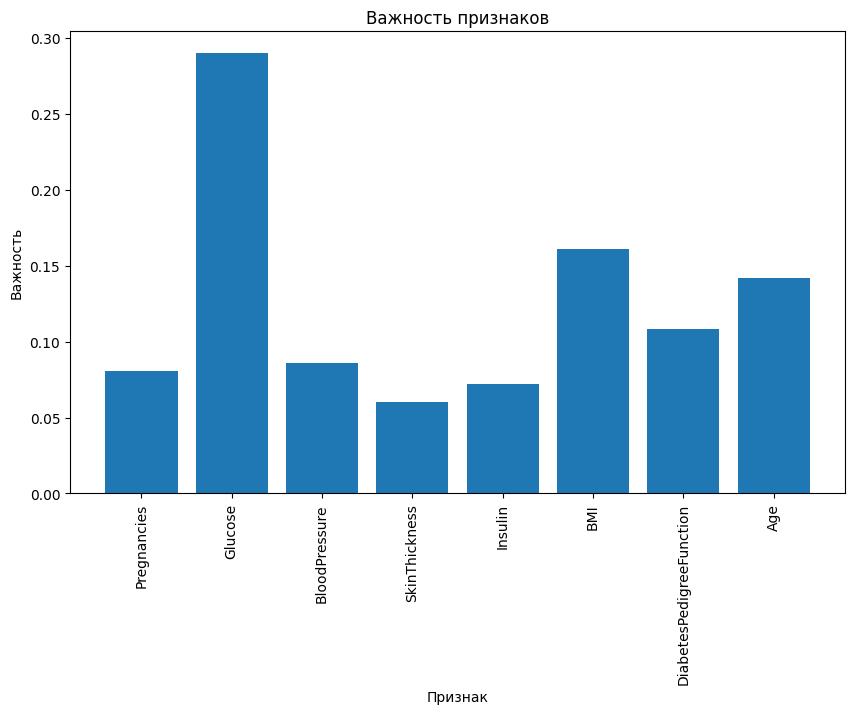

In [118]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
dt=RandomForestClassifier(n_estimators=50, random_state=42, max_depth=best_accuracy[0], min_samples_split=best_accuracy[1])
dt.fit(X_train, y_train)#Обучаем
importances=dt.feature_importances_#Находим важность признаков
features=list(X_train.columns)#Названия
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.title('Важность признаков')
plt.xticks(rotation=90)
plt.show()

Вовод: самым важным для определения диабета оказался признак Glucose